In [1]:
!pip install transformers datasets evaluate contractions accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import pandas as pd
import seaborn as sns
import string
import re
import contractions
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline, get_scheduler, default_data_collator
from accelerate import Accelerator
import collections
import evaluate
from tqdm.auto import tqdm
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

# Run locally
#DATA_PATH = ''

# KW
DATA_PATH = '/content/gdrive/MyDrive/TweetQA/'

# FZ
#DATA_PATH = 'gdrive/MyDrive/'

model_checkpoint = 'deepset/bert-base-cased-squad2'

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/gdrive


device(type='cuda', index=0)

## Load Data

In [3]:
train = pd.read_json(DATA_PATH + 'data/train.json')
train['id'] = train['qid']
train = train.drop(['qid'], axis=1)
dev = pd.read_json(DATA_PATH + 'data/dev.json')
dev['id'] = dev['qid']
dev = dev.drop(['qid'], axis=1)

train.head(10)

,Question,Answer,Tweet,id
0,at which school were first responders on the s...,[independence high school],"Our prayers are with the students, educators &...",0c871b7e5320d0816d5b2979d67c2649
1,what website is linked in the tweet?,[instagram],I can finally say it out loud and proud: I'm g...,02505974856f47bbe8b487c57778de1c
2,when does he say kaine is able?,"[5:09 pm- jul 22, 2016.]",KAINE IS ABLE!!!— Cory Booker (@CoryBooker) Ju...,d16eb85d141d5a87bfbc438afbcf50aa
3,what is up to us to keep doing?,[exploring],Cassini showed us the beauty of Saturn. It rev...,e6e40c7aa9a94b6bab363812ea1918b0
4,where can you see girls doing that?,[at the bar],"Nicki your video was just you twerking, I see ...",44041dedd11431be77e4a4cf5a8d0276
5,who did they kil on tape,[eric],"Sean Abbott - thinking about you too, mate!— K...",937b508b14363b9372ab989e551a6945
6,kaine took hundreds of thousands of dollars in...,[gifts],Is it the same Kaine that took hundreds of tho...,64816a176b245200cc9ebd480775bfe7
7,who say he's gay because he watches rupaul's d...,[andrew garfield],Andrew Garfield says he's gay because he watch...,724505d2deb93dd32ee0e49662e35536
8,what kind of contract did he have?,[a non-guaranteed contract],The Cavs have released Edy Tavares. No surpris...,a75c45c89e478073dfd2a078487460a3
9,what will senator rand paul do if he keeps oba...,[tax it],Shorter Obama: If you like your college saving...,6abbd8722a0fb5a5f58a89812d6d7e55


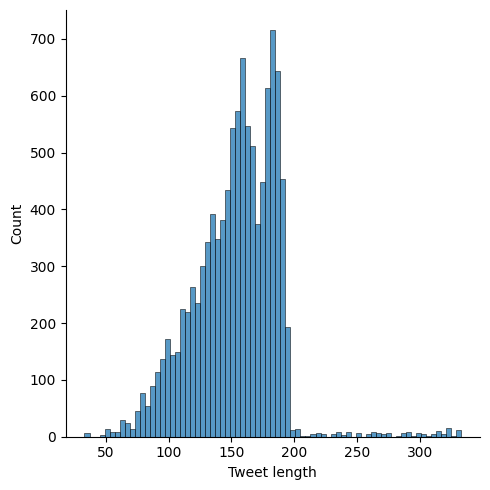

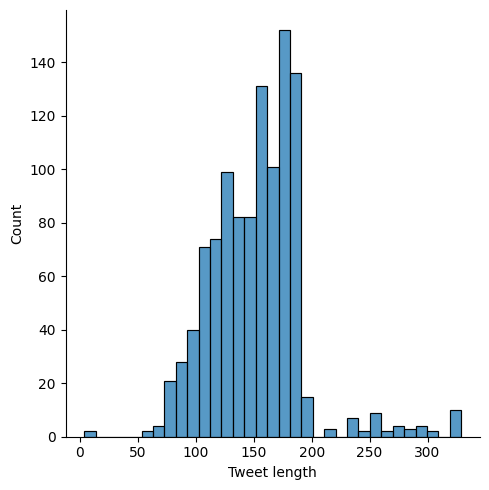

In [4]:
train['Tweet length'] = train.Tweet.apply(len)
sns.displot(train, x='Tweet length')

dev['Tweet length'] = dev.Tweet.apply(len)
sns.displot(dev, x='Tweet length')

train = train.drop(['Tweet length'], axis=1)
dev = dev.drop(['Tweet length'], axis=1)

## Preprocessing

### Preprocess data

In [5]:
def preprocessing(text):
    # Remove URLS
    text = re.sub(r"http\S+", "", text)

    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuations
    punctuationFree = []
    for i in text:
        if i not in string.punctuation:
            punctuationFree.append(i)
        else:
            punctuationFree.append(' '*len(i))
    punctuationFree = ''.join(punctuationFree)
    text = punctuationFree.strip()

    # Using contractions.fix to expand the shortened words
    expanded_words = []   
    for word in text.split():
        expanded_words.append(contractions.fix(word))  

    return text.lower()

In [6]:
train['Tweet'] = train['Tweet'].apply(lambda x: preprocessing(x))
dev['Tweet'] = dev['Tweet'].apply(lambda x: preprocessing(x))

### Find answer start index in the tweet

In [7]:
def answer_index_in_doc(answerList, doc):
    indices = []
    for each in answerList:
        index = doc.lower().find(each)
        if index != -1:
            indices.append(index)
    return answerList, indices

In [8]:
answer = []
for index, row in train.iterrows():
    answerList, indices = answer_index_in_doc(row['Answer'], row['Tweet'])
    #delete rows
    if len(indices) == 0:
        train = train.drop(index)
    else:
        answer.append({'text': answerList, 'answer_start': indices})

train['Answer'] = answer

answer = []
for index, row in dev.iterrows():
    answerList, indices = answer_index_in_doc(row['Answer'], row['Tweet'])
    #delete rows
    if len(indices) == 0:
        dev = dev.drop(index)
    else:
        answer.append({'text': answerList, 'answer_start': indices})

dev['Answer'] = answer

print(len(train))
print(len(dev))
train.head(10)

5436
776


,Question,Answer,Tweet,id
0,at which school were first responders on the s...,"{'text': ['independence high school'], 'answer...",our prayers are with the students educators ...,0c871b7e5320d0816d5b2979d67c2649
3,what is up to us to keep doing?,"{'text': ['exploring'], 'answer_start': [94]}",cassini showed us the beauty of saturn it rev...,e6e40c7aa9a94b6bab363812ea1918b0
4,where can you see girls doing that?,"{'text': ['at the bar'], 'answer_start': [63]}",nicki your video was just you twerking i see ...,44041dedd11431be77e4a4cf5a8d0276
6,kaine took hundreds of thousands of dollars in...,"{'text': ['gifts'], 'answer_start': [67]}",is it the same kaine that took hundreds of tho...,64816a176b245200cc9ebd480775bfe7
7,who say he's gay because he watches rupaul's d...,"{'text': ['andrew garfield'], 'answer_start': ...",andrew garfield says he s gay because he watch...,724505d2deb93dd32ee0e49662e35536
13,who is she celebrating?,"{'text': ['caitlyn'], 'answer_start': [16]}",let s celebrate caitlyn use her moment to up...,0b7832644d7495c056877dd193c830f8
15,who do we need more men like?,"{'text': ['drake'], 'answer_start': [22]}",we need more men like drake who will call out ...,52cf3948e68a8824ea5a055add2e0160
19,which celebrity does harnidh kaur think should...,"{'text': ['kendall jenner'], 'answer_start': [...",vogue india we ve completed 10 years in india...,7dd7078c90d7d9193d7a459baf65056a
20,what does molly have little of after reading?,"{'text': ['words'], 'answer_start': [14]}",i hardly have words after reading this wow o...,255e61dbac06fd9c167ac4e105e6df1c
22,where do people need to be evacuated?,"{'text': ['east aleppo'], 'answer_start': [100]}",i can t we can t all be happy until all the ...,850aab9a3ddf68a4c9c25c0a35ac5895


### Convert DataFrame to DatasetDict

In [9]:
train_dataset = Dataset.from_pandas(train)
train_dataset = train_dataset.remove_columns("__index_level_0__")

dev_dataset = Dataset.from_pandas(dev)
dev_dataset = dev_dataset.remove_columns("__index_level_0__")

data = DatasetDict({'train': train_dataset, 'dev': dev_dataset})
data

DatasetDict({
    train: Dataset({
        features: ['Question', 'Answer', 'Tweet', 'id'],
        num_rows: 5436
    })
    dev: Dataset({
        features: ['Question', 'Answer', 'Tweet', 'id'],
        num_rows: 776
    })
})

In [10]:
data['train'][0]

{'Question': 'at which school were first responders on the scene for?',
 'Answer': {'answer_start': [59], 'text': ['independence high school']},
 'Tweet': 'our prayers are with the students  educators   families at independence high school   all the first responders on the scene   patriotpride— doug ducey   dougducey  february 12  2016',
 'id': '0c871b7e5320d0816d5b2979d67c2649'}

### Pre-process training data

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 200
stride = 100

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["Question"]]
    inputs = tokenizer(
        questions,
        examples["Tweet"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["Answer"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [12]:
train_dataset = data["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=data["train"].column_names,
)
len(data["train"]), len(train_dataset)

Map:   0%|          | 0/5436 [00:00<?, ? examples/s]

(5436, 5436)

### Pre-process validation data

In [13]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["Question"]]
    inputs = tokenizer(
        questions,
        examples["Tweet"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [14]:
validation_dataset = data["dev"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=data["dev"].column_names,
)
len(data["dev"]), len(validation_dataset)

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

(776, 776)

## Training

In [15]:
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=32,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=32
)

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [16]:
optimizer = AdamW(model.parameters(), lr=2e-5)

# Accelerator
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

# Learning rate decay
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [17]:
metric = evaluate.load("squad")
n_best = 20
max_answer_length = 30

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["Tweet"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["Answer"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [18]:
output_dir = DATA_PATH + "bert-fine-tuned"
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, data["dev"]
    )
    print('epoch %d: exact_match %.4f, f1 %.4f' % (epoch+1, metrics['exact_match'], metrics['f1']))

    # Save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)

  0%|          | 0/510 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/776 [00:00<?, ?it/s]

epoch 1: exact_match 66.4948, f1 80.6711
Evaluation!


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/776 [00:00<?, ?it/s]

epoch 2: exact_match 67.0103, f1 80.9821
Evaluation!


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/776 [00:00<?, ?it/s]

epoch 3: exact_match 67.6546, f1 81.7184


## Prediction

In [21]:
model = AutoModelForQuestionAnswering.from_pretrained(DATA_PATH + 'bert-fine-tuned')
question_answerering = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

predictions = {'qid':[], 'Answer':[]}
for each in data['dev']:
    result = question_answerering(question=each['Question'], context=each['Tweet'])
    predictions['qid'].append(each['id'])
    predictions['Answer'].append(result['answer'])

predictions = pd.DataFrame(predictions)
predictions.head(10)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,qid,Answer
0,f867d1c3361549952be5639ca433895f,nj
1,f1c214d65d1cd73b457c1dba09f90013,water
2,c5e6eb7f974409ac4561fd1c2ba0fb58,m0nstarsbballwiggins
3,bfe50582de9a45aa047f155ba9ca3334,pizza
4,9c7b6346cd5446c195657f33a4b02eef,tsonga
5,b06bc7f7e91ba15ae1d7a08187e7647d,ahead of his first match in the daviscupfinal
6,92a9e9df93330c6c12bda8809c93c877,westgate
7,e01a36ec369bb9e1fa426af08542a3d5,looking at the hole cut in the wall as part of...
8,9c59b0eac1dffd71027c03957b4a7928,looking at the hole cut in the wall
9,9623cdedd192a9be82ece463f2083059,2009


In [22]:
predictions.to_json(DATA_PATH + 'bert_predictions.json', orient='records')